<a href="https://colab.research.google.com/github/stefanobinotto/Natural-Language-Processing-NLP-/blob/main/NeuralDependencyParsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Dependency Parsing

*   Binotto Stefano 2052421

*   Grotto Gionata 2052418



In the text cells of this notebook we describe the main ideas behind the related code cells. Inside the code cells we wrote comments to make clear the implementation details.

##Installing requirements

Installing libraries

In [ ]:
!pip install datasets  # huggingface library with dataset
!pip install conllu    # aux library for processing CoNLL-U format
!pip install transformers #install trasformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.6 MB/s eta 0:00:00


Importing packages

In [ ]:
import torch
import torch.nn as nn
from functools import partial
from datasets import load_dataset, logging
from transformers import AutoTokenizer, AutoModel, logging
logging.set_verbosity_warning() #to ignore warning messages
import matplotlib.pyplot as plt
import numpy as np

##Dataset

The treebank we chose from HuggingFace's database is the [UD English EWT](https://universaldependencies.org/treebanks/en_ewt/index.html), a Gold Standard Universal Dependencies Corpus for English.

We picked this dataset for 2 main reasons. The first one is that the corpus is pretty **broad**, since it's composed by **254,825 words** and **16,621 sentences**, obtained from **5 genres** of web media: weblogs, newsgroups, emails, reviews, and Yahoo! answers. The second reason is that dealing with English words made the tokenization debugging a little bit easier.

Since we noticed that some samples had in the "heads" list a few "None" values, we decided to discard all the related sentences during preprocessing.

###Data set-up: create training data and iterable dataloaders

Here are the functions we used to process the data to feed inside the models.



*   **is_projective()**: check whether the tree of a sentence is reprojective
*   **preprocess()**: discard all the sentences in the dataset which have at least one "None" value in their "heads" list
*   **create_dict()**: embedding dictionary which maps words (only if they have more than 3 occurences) to indeces





In [ ]:
#the function returns whether a tree of a sentence is projective or not
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

#discard from the given dataset all the samples whose "heads" list contains "None" values
def preprocess(dataset):
  count = 0
  clean_set = []
  for sentence in dataset:
    none_flag = False
    for head in sentence["head"]:
      if head == "None":
        none_flag = True
    if not none_flag:
      clean_set.append(sentence)
  return clean_set


#the function creates a dictionary of word/index pairs: our embeddings vocabulary
#threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

Here we load the training, validation and test sets. Then we clean them using *preprocess()* and *is_projective()* functions, and create the embedding dictionary. Finally, confront the datasets before and after the preprocessing.

In [ ]:
#loading datasets
train_dataset = load_dataset('universal_dependencies', 'en_ewt', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_ewt', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_ewt', split="test")

print("Number of samples before preprocessing:")
print("Train:\t", len(train_dataset))
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

#perform preprocess to clean sets
train_dataset = preprocess(train_dataset)
dev_dataset = preprocess(dev_dataset)
test_dataset = preprocess(test_dataset)

# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
dev_dataset = [sample for sample in dev_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
test_dataset = [sample for sample in test_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
# create the embedding dictionary: word ---> idx
emb_dictionary = create_dict(train_dataset)

print("Number of samples after preprocessing:")
print("Train:\t", len(train_dataset))
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/12543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2077 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_ewt/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


Number of samples before preprocessing:
Train:	 12543
Dev:	 2002
Test:	 2077
Number of samples after preprocessing:
Train:	 9966
Dev:	 1684
Test:	 1747


This **process_sample()** function is used to create the actual training sample by means of the oracle. We add the *ROOT* token at the leftmost position of the sentence, extract the gold tree and associate each configuration (β1, σ1) to the correct canonical action/transition. The configuration has only 2 elements since with ArcEager we only operate with those two.

In [ ]:
#returns a samples with:
# -enc_sentence: embedding sentence (integers)
# -gold path: configuration
# -gold_moves: canonical move associated to the configuration
# -gold: gold tree
def process_sample(sample, get_gold_path = False):

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  #gold tree
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  #embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record the topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 reduce 3 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration, only stack and buffer elements
      configuration = [parser.stack[-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move, respecting the precedences
      if oracle.is_left_arc_gold():
        parser.left_arc()
        gold_moves.append(0) # 0 is left
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1) # 1 is right
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(2) # 2 is reduce
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(3) # 3 is shift

  return enc_sentence, gold_path, gold_moves, gold

**prepare_batch()** is used to batch the training data.

In [ ]:
def prepare_batch(batch_data, get_gold_path=False):
  data = [process_sample(s, get_gold_path=get_gold_path) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  return sentences, paths, moves, trees

Finally, we create dataloaders for train, validation and test sets.
At this point we also set the best batch size we found for out models.

In [ ]:
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

###Dataset analysis

Here we analyze the lenght of the sentences that are inside each split (train, val, test) of the datasets. So, for each of them, it find the mean, the maximum and the minimum length of the sentences and then it plot an histogram that describes them.

Average number of words for each sentence: 14.486453943407586
Min number of words of a sentence: 1
Max number of words of a sentence: 102


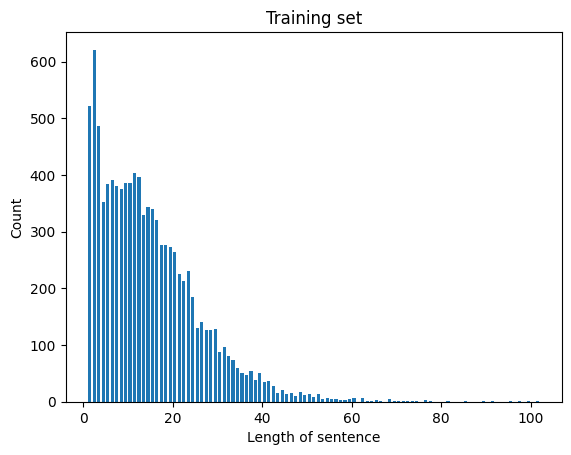

Average number of words for each sentence: 11.310570071258907
Min number of words of a sentence: 1
Max number of words of a sentence: 65


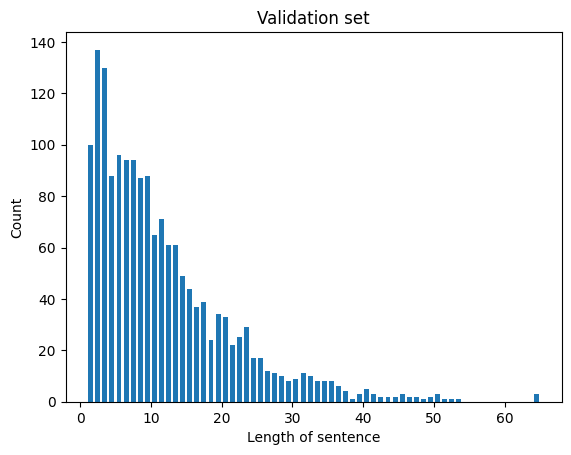

Average number of words for each sentence: 10.664567830566686
Min number of words of a sentence: 1
Max number of words of a sentence: 76


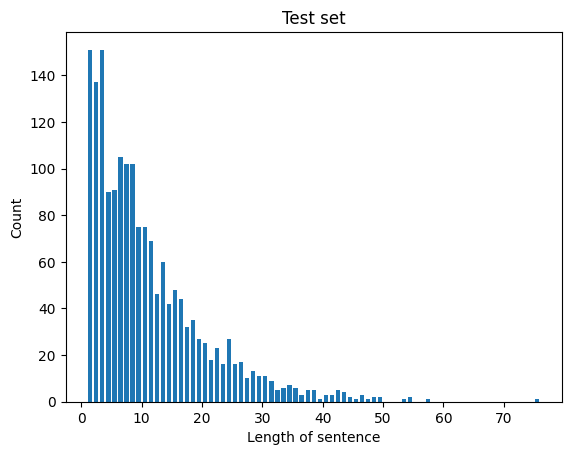

In [ ]:
#list of lengths of each sentence of training set
train_sentences_length = [len(sample['tokens']) for sample in train_dataset]
#list of lengths of each sentence of validation set
dev_sentences_length = [len(sample['tokens']) for sample in dev_dataset]
#list of lengths of each sentence of test set
test_sentences_length = [len(sample['tokens']) for sample in test_dataset]

#small function for statistics computation
def data_analysis(sentences):
  #compute average length of training sentences
  mean= np.sum(sentences)/len(sentences)
  #compute minimum length of training sentences
  min= np.min(sentences)
  #compute maximum length of training sentences
  max= np.max(sentences)
  print("Average number of words for each sentence: "+str(mean))
  print("Min number of words of a sentence: "+str(min))
  print("Max number of words of a sentence: "+str(max))

  #build the histogram leght-count
  plt.hist(sentences, rwidth=0.7 , histtype='bar', bins=range(min, max + 1))
  plt.xlabel("Length of sentence")
  plt.ylabel("Count")

#print statistics and plot the histograms
data_analysis(train_sentences_length)
plt.title("Training set")
plt.show()
data_analysis(dev_sentences_length)
plt.title("Validation set")
plt.show()
data_analysis(test_sentences_length)
plt.title("Test set")
plt.show()

## Arc-Eager
The arc-eager parser can perform 4 types of actions(transitions):

*   **shift**: remove β1 from the buffer and pushes it into the stack
*   **left-arc**: creates the arc  (β1→σ1), and removes σ1 from the stack
*   **right-arc**: creates the arc (σ1→β1), and then uses shift
*   **reduce**: pop σ1

with β1 = first element of the buffer, σ1 = topmost element of the stack







In [ ]:
class ArcEager:
  def __init__(self, sentence):
    self.sentence = sentence
    #buffer containing the words inside the sentence
    self.buffer = [i for i in range(len(self.sentence))]
    #stack is initially empty
    self.stack = []
    #list to store all the transitions
    self.arcs = [-1 for _ in range(len(self.sentence))]

    #shift move to initialize the stack
    self.shift()


  def shift(self):
    self.stack.append(self.buffer.pop(0))


  def reduce(self):
    self.stack.pop()


  def left_arc(self):
    top_most_stack = self.stack.pop()
    self.arcs[top_most_stack] = self.buffer[0]


  def right_arc(self):
    self.arcs[self.buffer[0]] = self.stack[-1]
    self.shift()


  #for arc-eager, no need to check for the stack size
  def is_tree_final(self):
    return len(self.buffer) == 0

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)

## Oracle
Keeping into account that the set of found dependencies does not contain any wrong dependency, the static oracle is based on the following conditions and follows this precedence:
1.   **left-arc** can be done only if it constructs a gold dependency and if the token σ1 is not the artificial root node and does not already
have a head.
2.   **right-arc** can be done only if it constructs a gold dependency
3.   **reduce** can be done only if σ1 has a head
4.   **shift transition** has lowest precedence, and can be done if the buffer is not empty

These are all the conditions indicated in the section 2 of the [provided paper](https://aclanthology.org/C12-1059.pdf).

In [ ]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  #check if the left arc can be performed
  def is_left_arc_gold(self):
    if len(self.parser.buffer) == 0 or len(self.parser.stack) == 0:
      return False
    #precondition: s1 must not be the root and must not have a head
    if self.parser.stack[-1] == 0 or self.parser.arcs[self.parser.stack[-1]] != -1:
      return False
    s1 = self.parser.stack[-1]
    b1 = self.parser.buffer[0]
    if self.gold[s1] == b1:
      return True
    return False


  #check if the right arc can be performed
  def is_right_arc_gold(self):
    if len(self.parser.buffer) == 0:
      return False
    s1 = self.parser.stack[-1]
    b1 = self.parser.buffer[0]
    if self.gold[b1] == s1:
      return True
    return False


  #check if the reduce can be performed
  def is_reduce_gold(self):
    if len(self.parser.stack) == 0:
      return False

    #precondition: the top token in stack must have a head
    if self.parser.arcs[self.parser.stack[-1]] == -1:
      return False

    #we only check missing dependents for the top-most element of the stack s1 to the right
    #since we assume A is correct and thus all left dependents
    #for s1 have already been collected
    for i in self.parser.buffer:
      if self.gold[i] == self.parser.stack[-1]:
        return False
    return True


  #check if shift can be performed
  def is_shift_gold(self):
    if len(self.parser.buffer) == 0:
      return False
    return True

##Models


In order to be able to perform a fair comparison as much as possible, both the models have the same MLP classifier architecture (same hidden and output layer size but different input size since the two models generate embeddings of different size).

###Baseline BiLSTM model  

In this section we implement the BiLSTM network. We used as starting point the model shown in the second laboratory of the NLP course and implemented our changes.

We start defining the parameters of the network:

In [ ]:
EMBEDDING_SIZE = 100
LSTM_SIZE = 200
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = 0.2

Next, we create our model. It consists of a Bi-LSTM to generate word embeddings using their left-to-right and right-to-left contexts (independently) and a feedforward network to predict the next move of the parser.

From the secon laboratory notebook we totally changed the *parse_step()* to adapt the model to Arc-Eager.
In addition, the dimension of the input layer of the MLP classifier has been adapted to accomodate the Arc-Eager configuration representation, which is 4 times the dimension of the LSTM output (concatenate forward+backward LSTMs for each of the 2 elements in the configuration). We also changed the size of the output layer of the classifier, since in Arc-Eager we have 4 possible actions.

 **In the code below more details in the explanatory comments**:


In [ ]:
class BiLSTM_Net(nn.Module):

  def __init__(self, device):
    super(BiLSTM_Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    #initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    #initialize feedforward:

    #the input of the first MLP layer is 4 times the size of the LSTM output
    #because we need to concatenate the forward and backward layers' output
    #for each of the two elements of the configuration (stack1, buffer1)
    self.w1 = torch.nn.Linear(2*2*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()

    #the output has size equal to 4 since it's the number of possible actions in arc-eager
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):
    #get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    #run the bi-lstm
    h = self.lstm_pass(x)

    #for each parser configuration that we need to score we arrange from the
    #output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    #run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  #get hidden representation h
  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h


  #generate the input for the MLP classifier by concatenation
  def get_mlp_input(self, configurations, h):
    mlp_input = []

    #each tensor is twice the LSTM output size
    #because it's the concatenation of forward and backward LSTMs
    #for each element in the configuration
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  #we use this function at inference time. We run the parser and at each step,
  #if all the conditions are met, we pick as next move the one with
  #the highest score assigned by the model, otherwise try with the other actions
  #following the precedence given by the score
  def infere(self, x): #x is a batch of sentences

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  #get current configuration for all the parsers
  def get_configurations(self, parsers):
    #in Arc-Eager a configuration has only two elements
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1]
      else:
        conf = [parser.stack[-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations


  #check if all the parsers have reached the final configuration
  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True


  #if parsers are not finished, for each parser left try to perform the highest score action
  #if allowed (conditions are described below), otherwise try the other actions
  #following the score precedence
  def parse_step(self, parsers, moves):
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        #sort the actions in decreasing score order
        moves_order = torch.argsort(moves[i], descending = True)
        #following the score order
        for move in moves_order:
          #left-arc
          if move == 0:
            #if the buffer is not empty and the topmost stack element is not
            #the ROOT, perform left-arc, otherwise try next move
            if len(parsers[i].buffer) != 0 and parsers[i].stack[-1] != 0:
              parsers[i].left_arc()
              break
            else:
              continue
          #right-arc
          elif move == 1:
            #if the buffer is not empty perform right-arc, otherwise try next move
            if len(parsers[i].buffer) != 0:
              parsers[i].right_arc()
              break
            else:
              continue
          #reduce
          elif move == 2:
            #if the topmost stack element is not the ROOT performe reduce, otherwise try next move
            if parsers[i].stack[-1] != 0:
              parsers[i].reduce()
              break
            else:
              continue
          #shift
          elif move == 3:
            #if the buffer is not empty perform shift, otherwise try next move
            if len(parsers[i].buffer) != 0:
              parsers[i].shift()
              break
            else:
              continue

###BERT model
In this section we implement the BERT network. We used as starting point the class shown in the *Baseline BiLSTM model* section of this notebook.

We start defining the parameters of the network:

In [ ]:
BERT_MLP_SIZE = 200
BERT_DROPOUT = 0.2

In this model, to generate a word embedding (with 768 features, since it is the size of output of the pretrained model) using a pretrained BERT, after the subword tokenization, we chose to consider only the embedding of the **left-most token** for each word and compute it by averaging the output of the last **4 layers** of the encoder, according to this [article](https://towardsdatascience.com/nlp-extract-contextualized-word-embeddings-from-bert-keras-tf-67ef29f60a7b#:~:text=I%20guess%20this%20depends%20on%20the%20task%20but%20empirically%2C%20the%20authors%20identified%20that%20one%20of%20the%20best%20performing%20choices%20was%20to%20sum%20the%20last%204%20layers%2C%20which%20is%20what%20we%20will%20be%20doing). Previously, we also tried to use the output of just the last layer or last 2 layers but the scores were worse.

Here are the our functions we added:

*   **process_BERT_input**: for each sentence in the batch, tokenize it and discard all the tokens which are not the leftmost token of a word (check if they start with '*##*'). Then, create a list with these remained tokens. At the end tokenize all these lists of the batch again in order to insert the "PAD" tokens.
*   **get_embeddings**: feed the batch in the model and, for each word (leftmost token), generate the embedding by averaging the output of the 4 topmost encoder layers.

The *forward()* method was slightly modified in order to call the two functions presented above.

All the other functions are the same as the Bi-LSTM model above.

We decided to fine-tune the whole pre-trained BERT, rather than freeze all its parameters or fine-tune only its last layers. This choice is explained in the "*Comparison between Bi-LSTM and BERT models*" section at the end of this notebook.




**In the code below more details in the explanatory comments**:

In [ ]:
class BERTNet(nn.Module):

  def __init__(self, device):
    super(BERTNet, self).__init__()
    self.device = device
    self.model = AutoModel.from_pretrained("bert-base-uncased")
    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    #add the new special words in the vocabulary of the tokenizer, to force them to not be tokenized
    self.tokenizer.add_tokens(["<ROOT>", "<unk>"])

    #increase the size of the embedding matrix
    self.model.resize_token_embeddings(len(self.tokenizer))

    # initialize feedforward

    #the input of the first MLP layer is 4 times the size of the LSTM output
    #because we need to concatenate the forward and backward layers' output
    #for each of the two elements of the configuration (stack1, buffer1)
    self.w1 = torch.nn.Linear(2*768, BERT_MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()

    #the output has size equal to 4 since it's the number of possible actions in arc-eager
    self.w2 = torch.nn.Linear(BERT_MLP_SIZE, 4, bias=True) # 4 is the number of possible actions in arc-eager
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(BERT_DROPOUT)

  #for each sentence in the batch, tokenize it, keep only the leftmost tokens,
  #concatenate the remained tokens and tokenize again to insert the <PAD> tokens
  def process_BERT_input(self, batch):
    #batch sentences
    sentences = []
    for sentence in batch:
      #sentence converted from idxs to words
      words = []
      #we need to reconvert the input sentences from indeces format to words
      for index_word in sentence:
        if index_word in emb_dictionary.values():
          for key,value in emb_dictionary.items():
            if value == index_word:
              words.append(key)
        else:
             words.append("<unk>")
      tokens_indeces = self.tokenizer(words, is_split_into_words=True, add_special_tokens=False)["input_ids"]
      # list with all individual tokens of the sentence
      tokens = self.tokenizer.convert_ids_to_tokens(tokens_indeces)

      #remove tokens starting with "##" to get only the leftmost token for each input word
      tmp_sentence= []
      for i in tokens:
        if i.startswith("##"):
          continue
        else:
          tmp_sentence.append(i)

      sentences.append(tmp_sentence)

    #re-tokenize with the "padding" argument set to True and get a tensor
    tokenized_batch = self.tokenizer(sentences, is_split_into_words=True, add_special_tokens=False, padding=True, return_tensors='pt')

    return tokenized_batch

  #get the average of the 4 topmost layers as word embedding
  def get_embeddings(self, batch):

    #preprocessed tokenized batch
    tok_batch = self.process_BERT_input(batch).to(self.device)

    #feed the batch in the model
    BERT_output = self.model(**tok_batch, output_hidden_states=True)

    #get the output of the 4 topmost encoder layers
    last_4_states = (BERT_output.hidden_states)[-4:] # shape: (4_layers) x (batch_size x seq_len x hidden_dim)
    tmp = torch.stack(last_4_states) # shape: 4_layers x batch_size x seq_len x hidden_dim
    #average
    embeddings = torch.mean(tmp, dim=0).to(self.device)

    return embeddings

  def forward(self, x, paths):

    #get embeddings
    embeddings = self.dropout(self.get_embeddings(x)).to(self.device)
    #convert to shape: seq_len x batch_size x hidden_dim
    h = embeddings.permute(1, 0, 2)

    # for each parser configuration that we need to score we arrange from the
    # output of BERT the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  #generate the input for the MLP classifier by concatenation
  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(768, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  #we use this function at inference time. We run the parser and at each step,
  #if all the conditions are met, we pick as next move the one with
  #the highest score assigned by the model, otherwise try with the other actions
  #following the precedence given by the score
  def infere(self, x): #x is a batch of sentences

    parsers = [ArcEager(i) for i in x]

    x = self.dropout(self.get_embeddings(x)).to(self.device)
    h = x.permute(1,0,2)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  #get current configuration for all the parsers
  def get_configurations(self, parsers):
    #in Arc-Eager a configuration has only two elements

    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1]
      else:
        conf = [parser.stack[-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  #check if all the parsers have reached the final configuration
  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  #if parsers are not finished, for each parser left try to perform the highest score action
  #if allowed (conditions are described below), otherwise try the other actions
  #following the score precedence
  def parse_step(self, parsers, moves):
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        #sort the actions in decreasing score order
        moves_order = torch.argsort(moves[i], descending = True)
        #following the score order
        for move in moves_order:
          #left-arc
          if move == 0:
            #if the buffer is not empty and the topmost stack element is not
            #the ROOT, perform left-arc, otherwise try next move
            if len(parsers[i].buffer) != 0 and parsers[i].stack[-1] != 0:
              parsers[i].left_arc()
              break
            else:
              continue
          #right-arc
          elif move == 1:
            #if the buffer is not empty perform right-arc, otherwise try next move
            if len(parsers[i].buffer) != 0:
              parsers[i].right_arc()
              break
            else:
              continue
          #reduce
          elif move == 2:
            #if the topmost stack element is not the ROOT performe reduce, otherwise try next move
            if parsers[i].stack[-1] != 0:
              parsers[i].reduce()
              break
            else:
              continue
          #shift
          elif move == 3:
            #if the buffer is not empty perform shift, otherwise try next move
            if len(parsers[i].buffer) != 0:
              parsers[i].shift()
              break
            else:
              continue

##Training and Validating


###Useful functions
Now we define some utility functions for training, testing and plotting learning curves.

First we define our evaluation function. We use UAS (Unlabeled Accuracy Score) which is the percentage of correct arcs predicted over all the arcs.

In [ ]:
#Compute UAS
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

Next, we define our train loop and the test function to run inference.

In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

We also define a function to compute the **Exponentially Weighted Moving Average**, which is a statistical measure used to model or describe a time series. The moving average is designed as such that older observations are given lower weights.
The weights fall exponentially as the data point gets older, hence the name exponentially weighted.
We imported the same script we used in an assignment for the *3D Data Processing* course.

We'll use this function when we'll plot the training e validation uas curves for better visualizing the trend of the metrics.

In [ ]:
#Return the Exponentially Weighted Moving Average
#for better visualizing the "trend" of the metrics
def numpy_ewma_vectorized_v2(data, window=10):
    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

We define this function to print the number of **learnable parameters** of the model.

In [ ]:
def count_parameters(model):
    print("Number of learnable parameters: "+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

###Bi-LSTM Model Training

The tuning of the parameters of this Bi-LSTM model was pretty tiring since, given a temporary small test dataset, the validation (and also test) UAS sometimes was different from the previous tests. In fact, using the small dataset **en_lines** used also in the second laboratory, we once reached 0.83 of UAS. However, in the successive runs, with the same parameters, the UAS was lower than 0.7. We still can't figure out what was the reason. With our final en_ewt dataset we never came close to that peak.

We coded the training process in order to use a Dynamic Learning Rate, which is reduced to 80% of the previous value every 3 epochs. This proved to be the highest score technique.

At the beginning of the training we print the number of parameters of the BiLSTM model we are about to train.

At the end of the training, we store the model that got the highest validation score to use in the final test evaluation.

At the end of the training cell we plot the learning curves of training loss and validation UAS.

The following training hyperparameters, and the parameters of the network declared in the *Baseline BiLSTM model* section, are the ones that give us the best scores.

Bi-LSTM training hyperparameters:

In [ ]:
BILSTM_EPOCHS = 15
BILSTM_LR = 0.01

Training and validating:

Device: cuda
Number of learnable parameters: 1181304


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch:   0 | avg_train_loss: 0.993 | dev_uas: 0.660 | Saving model 
Epoch:   1 | avg_train_loss: 0.914 | dev_uas: 0.697 | Saving model 
Epoch:   2 | avg_train_loss: 0.892 | dev_uas: 0.714 | Saving model 
Adjusting learning rate of group 0 to 8.0000e-03.
Epoch:   3 | avg_train_loss: 0.881 | dev_uas: 0.724 | Saving model 
Epoch:   4 | avg_train_loss: 0.871 | dev_uas: 0.732 | Saving model 
Epoch:   5 | avg_train_loss: 0.864 | dev_uas: 0.726 |
Adjusting learning rate of group 0 to 6.4000e-03.
Epoch:   6 | avg_train_loss: 0.858 | dev_uas: 0.742 | Saving model 
Epoch:   7 | avg_train_loss: 0.853 | dev_uas: 0.746 | Saving model 
Epoch:   8 | avg_train_loss: 0.850 | dev_uas: 0.747 | Saving model 
Adjusting learning rate of group 0 to 5.1200e-03.
Epoch:   9 | avg_train_loss: 0.846 | dev_uas: 0.749 | Saving model 
Epoch:  10 | avg_train_loss: 0.843 | dev_uas: 0.744 |
Epoch:  11 | avg_train_loss: 0.841 | dev_uas: 0.751 | Saving model 
Adjusting le

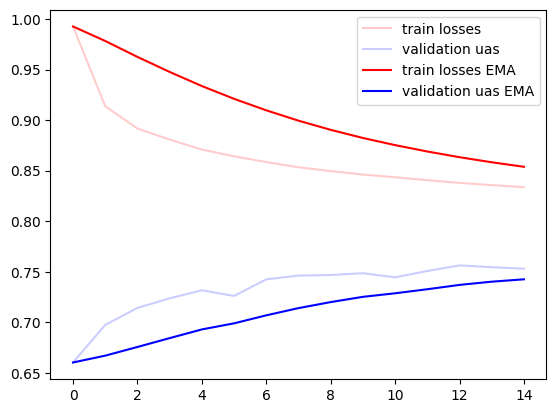

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
#define BiLSTM model
BiLSTM_model = BiLSTM_Net(device)
#print the number of learnable parameters
count_parameters(BiLSTM_model)

BiLSTM_model.to(device)

#define CE loss
criterion = nn.CrossEntropyLoss()
#Adam optimizer
optimizer = torch.optim.Adam(BiLSTM_model.parameters(), lr=BILSTM_LR)
#adaptive learning rate
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8, verbose=True)

#memory for curves plotting
validation_uas_losses, avg_train_losses = [] , []
#memory for save best model
best_BiLSTM_model = BiLSTM_model.state_dict()
best_val_uas = 0

for epoch in range(BILSTM_EPOCHS):
  #training loss
  avg_train_loss = train(BiLSTM_model, train_dataloader, criterion, optimizer)
  #validation UAS
  val_uas = test(BiLSTM_model, dev_dataloader)
  #store train loss of the current epoch
  avg_train_losses.append(avg_train_loss)
  #store validation UAS of the current epoch
  validation_uas_losses.append(val_uas)

  #decay of the LR every 5 epochs
  if epoch!= 0 and epoch%3==0:
    scheduler.step()

  #save best model for test evaluation
  if val_uas > best_val_uas:
    best_val_uas = val_uas
    print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} | Saving model ".format( epoch, avg_train_loss, val_uas))
    best_BiLSTM_model = BiLSTM_model.state_dict()
  else:
    print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

#plot train losses
plt.plot(avg_train_losses, label="train losses", color='r', alpha=0.2)
#plot validation UAS
plt.plot(validation_uas_losses, label="validation uas", color='b', alpha=0.2)
#plot train losses EWMA
plt.plot(numpy_ewma_vectorized_v2(np.array(avg_train_losses)), label="train losses EMA", color='r')
#plot validation uas EWMA
plt.plot(numpy_ewma_vectorized_v2(np.array(validation_uas_losses)), label="validation uas EMA", color='b')
plt.legend()

###BERT Model Training



We coded the training process in order to use a Dynamic Learning Rate, which is reduced to the 90% of the previous value every epoch. We got some pretty good UAS improvements.

At the beginning of the training we print the number of parameters of the BERT model we are about to train.

At the end of the training, we store the model that got the highest validation score to use in the final test evaluation.

At the end of the training cell we plot the learning curves of training loss and validation UAS.

The following training hyperparameters, and the parameters of the network declared in the *BERT model* section, are the ones that give us the best scores.

BERT training hyperparameters:

In [ ]:
BERT_EPOCHS = 15
BERT_LR = 0.0002

Training and validating:

Device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of learnable parameters: 109791980
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch:   0 | avg_train_loss: 0.942 | dev_uas: 0.795 | Saving model 
Adjusting learning rate of group 0 to 1.8000e-04.
Epoch:   1 | avg_train_loss: 0.859 | dev_uas: 0.810 | Saving model 
Adjusting learning rate of group 0 to 1.6200e-04.
Epoch:   2 | avg_train_loss: 0.841 | dev_uas: 0.819 | Saving model 
Adjusting learning rate of group 0 to 1.4580e-04.
Epoch:   3 | avg_train_loss: 0.832 | dev_uas: 0.818 |
Adjusting learning rate of group 0 to 1.3122e-04.
Epoch:   4 | avg_train_loss: 0.826 | dev_uas: 0.819 | Saving model 
Adjusting learning rate of group 0 to 1.1810e-04.
Epoch:   5 | avg_train_loss: 0.820 | dev_uas: 0.826 | Saving model 
Adjusting learning rate of group 0 to 1.0629e-04.
Epoch:   6 | avg_train_loss: 0.812 | dev_uas: 0.835 | Saving model 
Adjusting learning rate of group 0 to 9.5659e-05.
Epoch:   7 | avg_train_loss: 0.805 | dev_uas: 0.837 | Saving model 
Adjusting learning rate of g

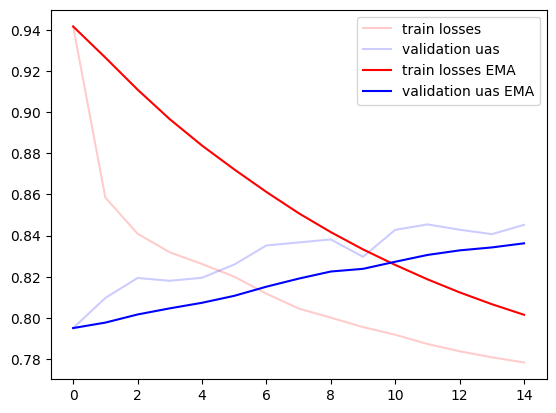

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
#define BERT model
BERT_model = BERTNet(device)
#print the number of learnable parameters
count_parameters(BERT_model)

BERT_model.to(device)

#define CE loss
criterion = nn.CrossEntropyLoss()
#Adam optimizer
optimizer = torch.optim.Adam(BERT_model.parameters(), lr=BERT_LR)

#adaptive learning rate
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)


#memory for curves plotting
validation_uas_losses, avg_train_losses = [] , []
#memory for save best model
best_BERT_model = BERT_model.state_dict()
best_val_uas = 0

for epoch in range(BERT_EPOCHS):
  #training loss
  avg_train_loss = train(BERT_model, train_dataloader, criterion, optimizer)
  #plot validation UAS
  val_uas = test(BERT_model, dev_dataloader)
  #store train loss of the current epoch
  avg_train_losses.append(avg_train_loss)
  #store validation UAS of the current epoch
  validation_uas_losses.append(val_uas)

  #save best model
  if val_uas > best_val_uas:
    best_val_uas = val_uas
    print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} | Saving model ".format( epoch, avg_train_loss, val_uas))
    best_BiLSTM_model = BiLSTM_model.state_dict()
  else:
    print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))
  scheduler.step()


#plot train losses
plt.plot(avg_train_losses, label="train losses", color='r', alpha=0.2)
#plot validation UAS
plt.plot(validation_uas_losses, label="validation uas", color='b', alpha=0.2)
#plot train losses EWMA
plt.plot(numpy_ewma_vectorized_v2(np.array(avg_train_losses)), label="train losses EMA", color='r')
#plot validation uas EWMA
plt.plot(numpy_ewma_vectorized_v2(np.array(validation_uas_losses)), label="validation uas EMA", color='b')
plt.legend()

##Evaluation

Use the best Bi-LSTM model, that we saved during the training, for the final evaluation:

In [ ]:
test_model = BiLSTM_Net(device)
test_model.load_state_dict(best_BiLSTM_model)
test_model.to(device)
test_uas = test(test_model, test_dataloader)
print("test_uas: {:5.3f}".format(test_uas))

test_uas: 0.753


Use the best BERT model, that we saved during the training, for the final evaluation:

In [ ]:
test_model = BERTNet(device)
test_model.load_state_dict(best_BERT_model)
test_model.to(device)
test_uas = test(test_model, test_dataloader)
print("test_uas: {:5.3f}".format(test_uas))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


test_uas: 0.844


###Comparison between Bi-LSTM and BERT models

Table 1

| Model | # learnable parameters |  
| :-: | -: |
| BiLSTM | 1181304 |
| BERT | 109791980 |

Table 2

| BiLSTM | Average training loss | Validation UAS |  
| :-: | :-: | :-: |
| Epoch 1 | 0.993  | 0.660  |
| Epoch 2 | 0.914  | 0.697  |
| Epoch 3 | 0.892  | 0.714  |
| Epoch 4 | 0.881  | 0.724  |
| Epoch 5 | 0.871  | 0.732  |
| Epoch 6 | 0.864  | 0.726  |
| Epoch 7 | 0.858  | 0.742  |
| Epoch 8 | 0.853  | 0.746  |
| Epoch 9 | 0.850  | 0.747  |
| Epoch 10 | 0.846  | 0.749  |
| Epoch 11 | 0.843  | 0.744  |
| Epoch 12 | 0.841  | 0.751  |
| Epoch 13 | 0.838  | 0.756  |
| Epoch 14 | 0.836  | 0.754  |
| Epoch 15 | 0.834  | 0.753  |

Table 3

| BERT | Average training loss | Validation UAS |  
| :-: | :-: | :-: |
| Epoch 1 | 0.942 | 0.795  |
| Epoch 2 | 0.859 | 0.810  |
| Epoch 3 | 0.841 | 0.819  |
| Epoch 4 | 0.832 | 0.818  |
| Epoch 5 | 0.826 | 0.819  |
| Epoch 6 | 0.820 | 0.826  |
| Epoch 7 | 0.812 | 0.835  |
| Epoch 8 | 0.805 | 0.837  |
| Epoch 9 | 0.800 | 0.838  |
| Epoch 10 | 0.796 | 0.830  |
| Epoch 11 | 0.792 | 0.843  |
| Epoch 12 | 0.787 | 0.845  |
| Epoch 13 | 0.784 | 0.843  |
| Epoch 14 | 0.781 | 0.841  |
| Epoch 15 | 0.778 | 0.845  |

Table 4

| Model | test UAS |  
| :-: | :-: |
| BiLSTM | 0.753 |
| BERT | 0.844 |

As specified previously, to make a comparison as fair as possible, we kept the
same classifier on top of the BiLSTM and BERT models, except for the input layer size which depends on the size of the output of the previous model.



*   As expected the BERT model (*Table 3*) **outperformed** the Bi-LSTM model (*Table 2*). We expected this results since the BERT architecture corresponds to the Transformer Encoder which is way more complex and can capture bidirectional context information better than traditional bidirectional RNN units, like GRU or LSTM.
BERT exploits the Multi-Head **Self Attention** (**without** masking), which encodes the forward and backward contexts jointly.
Another possible reason is that BERT has more features for representing each word. In fact, in BiLSTM each word is embedded into a vector with 400 features, while BERT uses **768-dimensional vectors**. However, when we tried to increase the size of the BiLSTM embedding to 768 features, the UAS score dropped a lot.

*   To sum up so far, if we look at the *Table 1* above in which we can see that BERT has way more parameters to tune and learn, we can say that the BERT model can learn more informations than typical RNN architectures like BiLSTM, given the same dataset and the same number of epochs, due to the Transformer-based architecture and self-attention mechanism. On the other hand, the BiLSTM model is way **lighter** and **faster** to train (BiLSTM: 25 min, BERT: 70 min).

*   Initially we just tried to do **feature extraction** with BERT, so we froze all the parameters of the pretrained model and just learnt the ones of the classifier. However the UAS couldn't even come close to 0.700.
So we tried with the **fine tuning**. We froze only the first 10 layers of the encoder and fine tuned the 2 topmost layers and the score increased. It did increase even more with the fine tuning of the 4 and then 6 topmost encoder layers (a little more than 0.800). So, finally, we decided to fine tune the whole model and the UAS score increased a lot (*Table 4*).

###Comparison with SoTA


In the following table we inserted the UAS of our models that we obtained in the last run, so they are printed in the cells above, and those of the most performing approaches for Neural Dependency Parsing. We extracted the leaderboard measurements from [here](https://arxiv.org/pdf/1904.02099v3.pdf) and [here](https://aclanthology.org/2021.sigtyp-1.5.pdf).

| Model | UAS (on en_ewt dataset) |
| :-: | :-: |
| UDPipe 2.0+ BERT + Flair | 0.93 |
| UDify 2.0 | 0.91 |
| UDPipe 2.0 | 0.90 |
| BiLSTM (Ours) | 0.753 |
| BERT (Ours) | 0.844 |

Considering the table above, we can say that our best model, the one with BERT, is performing 0.086 worse than the SoTA approach *UDPipe 2.0 + BERT + Flair*, which is actually not a bad result for a team of two master students at their first NLP course.

To improve the UAS, we assume that maybe we could implement a more complex network, as the SoTA models do, with higher capacity and use a bigger dataset, however this would require bigger computational resources than Google Colab and a deeper knowledge of this field of study.